# Predicting blood's geloucos level using LSTM network

## Project Members
* Amir Mohammad Fallah (970122680014)

### Including requirements

In [116]:
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import pandas as pd 
import io
import os

### Converting time series to supervised problem

In [4]:
def series_to_supervised(data, n_in=2, n_out=2, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Loading dataset into pandas dataframe

In [141]:
dataframe = pd.read_csv('dataset/data.csv')
# drop missing data
dataframe = dataframe.dropna()
dataframe = dataframe.drop("PtID",axis=1)
values = dataframe.values
values = values.astype('float32')

### Scaling geloucos data range of 0 to 1

In [142]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaledContinues = scaler.fit_transform(dataframe[["Glucose"]])
reframed = series_to_supervised(scaledContinues,2,2)

### Split dataset into train, validation and test sets

In [143]:
values = reframed.values
n_train_len = int(len(values) * 0.7)
n_val_len = int(n_train_len * 0.1)


train = values[:n_train_len - n_val_len, :]
val = values[n_train_len - n_val_len:n_train_len, :]
test = values[n_train_len:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [144]:
train_X

array([[0.44475138, 0.43093923, 0.5441989 ],
       [0.43093923, 0.5441989 , 0.47237569],
       [0.5441989 , 0.47237569, 0.43370166],
       ...,
       [0.72651934, 0.75966851, 0.77071823],
       [0.75966851, 0.77071823, 0.79558011],
       [0.77071823, 0.79558011, 0.79834254]])

### Reshape input to be 3D [samples, timesteps, features]

In [145]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

### Build LSTM network

In [154]:
optimizer = keras.optimizers.Adam(lr=0.00001)


model = None
# building the model
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(70, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(65, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1 ,activation="linear"))
model.compile(loss = 'mean_absolute_error', optimizer = optimizer, metrics = ['mse'])

### Fit network on prepared sets

In [155]:
history = model.fit(train_X, train_y, epochs=100, validation_data=(val_X, val_y), verbose=1, shuffle=False)


Train on 25198 samples, validate on 2799 samples
Epoch 1/100
25198/25198 [==============================] - 2s 67us/step - loss: 0.3401 - mse: 0.1627 - val_loss: 0.3059 - val_mse: 0.1414
Epoch 2/100
25198/25198 [==============================] - 1s 45us/step - loss: 0.2146 - mse: 0.0757 - val_loss: 0.1669 - val_mse: 0.0501
Epoch 3/100
25198/25198 [==============================] - 1s 46us/step - loss: 0.1373 - mse: 0.0300 - val_loss: 0.1297 - val_mse: 0.0271
Epoch 4/100
25198/25198 [==============================] - 1s 48us/step - loss: 0.1169 - mse: 0.0205 - val_loss: 0.1121 - val_mse: 0.0193
Epoch 5/100
25198/25198 [==============================] - 1s 48us/step - loss: 0.0996 - mse: 0.0149 - val_loss: 0.0920 - val_mse: 0.0130
Epoch 6/100
25198/25198 [==============================] - 1s 47us/step - loss: 0.0776 - mse: 0.0094 - val_loss: 0.0657 - val_mse: 0.0070
Epoch 7/100
25198/25198 [==============================] - 1s 48us/step - loss: 0.0516 - mse: 0.0048 - val_loss: 0.0366 - v

25198/25198 [==============================] - 1s 45us/step - loss: 0.0163 - mse: 0.0016 - val_loss: 0.0138 - val_mse: 0.0014
Epoch 60/100
25198/25198 [==============================] - 1s 45us/step - loss: 0.0163 - mse: 0.0016 - val_loss: 0.0138 - val_mse: 0.0014
Epoch 61/100
25198/25198 [==============================] - 1s 45us/step - loss: 0.0163 - mse: 0.0016 - val_loss: 0.0138 - val_mse: 0.0014
Epoch 62/100
25198/25198 [==============================] - 1s 45us/step - loss: 0.0163 - mse: 0.0016 - val_loss: 0.0138 - val_mse: 0.0014
Epoch 63/100
25198/25198 [==============================] - 1s 45us/step - loss: 0.0163 - mse: 0.0016 - val_loss: 0.0138 - val_mse: 0.0014
Epoch 64/100
25198/25198 [==============================] - 1s 45us/step - loss: 0.0163 - mse: 0.0016 - val_loss: 0.0138 - val_mse: 0.0014
Epoch 65/100
25198/25198 [==============================] - 1s 46us/step - loss: 0.0163 - mse: 0.0016 - val_loss: 0.0138 - val_mse: 0.0014
Epoch 66/100
25198/25198 [==============

### Plot loss graph

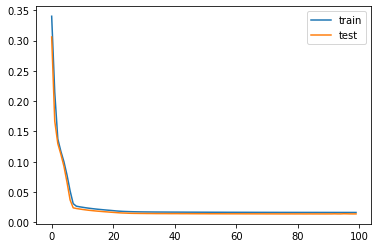

In [156]:
pyplot.title("")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Making predictions and evaluating model performance

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)